In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
from pathlib import Path

python(5048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In this Notebook we treat single sensor data for the setup1. We find the calibration coefficient W/V. We graphicate Laser power-Mean optical power, Laser power-Mean reference PD and Mean reference PD-Mean optical power. We also characterize the effect of temperature to the first two graphs.

In [3]:
def GetNumberOfFiles(wavelength,folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if wavelength in filename:
            count += 1
    print(f"Number of files in the folder with {wavelength} in their name: {count}")
    return count


In [4]:
def temp_distr_1(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Temperature=[]

    for i in range(1, nfile+1):
        #filename = f'{folder_path}/calibration_24072024_PD_{wavelength}_{i}.txt'
        #filename = f'{folder_path}/temperatura_22_26072024_PD_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]
        
        Temp=T['Temp'].tolist()

#Fem una llista amb tots les temperatures de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
        
    # Create a dictionary to count the occurrences
    frequency_dict = {}
    for number in Temperature:
        if number in frequency_dict:
            frequency_dict[number] += 1 #l'hi suma 1 si ja hi apareix
        else:
            frequency_dict[number] = 1 #sino en posa 1



    # Extract keys (numbers) and values (frequencies) from the dictionary
    Temperature = list(frequency_dict.keys())
    frequencies = list(frequency_dict.values())

    print(Temperature)
    print(frequencies)

    # Plotting the bar chart
    plt.bar(Temperature, frequencies, 0.09)
    plt.xlabel('Temperature ºC')
    plt.title(f'Frequency of Temperatures for the {wavelength} nm wavelength')
    #plt.xlim(19,22)
    plt.show()    
        

In [5]:
def temp_distr_2(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Temperature=[]

    if wavelength == '532':
        # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wavelength == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    for i in range(1, nfile+1):
        filename = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_{temp}_PM_MM_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date','time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        Temp=T['Temp'].tolist()

#Fem una llista amb tots les temperatures de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
        

    # Create a dictionary to count the occurrences
    frequency_dict = {}
    for number in Temperature:
        if number in frequency_dict:
            frequency_dict[number] += 1 #l'hi suma 1 si ja hi apareix
        else:
            frequency_dict[number] = 1 #sino en posa 1



    # Extract keys (numbers) and values (frequencies) from the dictionary
    Temperature = list(frequency_dict.keys())
    frequencies = list(frequency_dict.values())

    print(Temperature)
    print(frequencies)

    # Plotting the bar chart
    plt.bar(Temperature, frequencies, 0.09)
    plt.xlabel('Temperature ºC')
    plt.title(f'Frequency of Temperatures for the {wavelength} nm wavelength')
    #plt.xlim(20,24)
    plt.show()    
        

In [6]:
#temp_distr_1('./Useful_data/setup1/Calibration_july_2024/data/1064nm','1064')
#temp_distr_1('./Useful_data/setup1/Calibration_july_2024/data/532nm','532')
#temp_distr_2('./Useful_data/setup1/Calibration_december_2023/data/1064nm','1064')
#temp_distr_2('./Useful_data/setup1/Calibration_december_2023/data/532nm','532')
#temp_distr_1('./Useful_data/setup1/Temperatura_22_2024/data/532nm','532')
#temp_distr_1('./Useful_data/setup1/Temperatura_22_2024/data/1064nm','1064')

In [7]:
def Sensor_setup1(folder_path,txtname,filter,wavelength):   
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    Tpedestalfull= pd.DataFrame()
    foldername=os.path.basename(os.path.dirname(os.path.dirname(folder_path)))
    outputpath =  f'./Plots/setup1/{foldername}/{wavelength}nm/{filter}/'
    print(foldername)

#./Useful_data/setup1/Calibration_december_2023/data/1064nm
    # Define the variable pairs
    pairs = [
        ('meanRefPD', 'meanPM', 'slopes1', 'intercepts1', 'rCoes1', 'stderr1', 'intercepts_stderr1'),
        ('L', 'meanPM', 'slopes2', 'intercepts2', 'rCoes2', 'stderr2', 'intercepts_stderr2'),
        ('L', 'meanRefPD', 'slopes3', 'intercepts3', 'rCoes3', 'stderr3', 'intercepts_stderr3')
    ]

    # Initialize lists
    slopes,slopes1, slopes2, slopes3= [], [], [], []
    intercepts, intercepts1, intercepts2, intercepts3= [], [], [], []
    rCoes, rCoes1, rCoes2, rCoes3= [], [], [], []
    slopes_stderr, stderr1, stderr2, stderr3= [], [], [], []
    intercepts_stderr, intercepts_stderr1, intercepts_stderr2, intercepts_stderr3 = [], [], [], []
    #We generate a vector where we will save the mean temperature for each folder
    Tm=[]

    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")
    else:
        print(f"Directory '{outputpath}' already exists.")

    if wavelength == '532':
        # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wavelength == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    nfile = 3
    for i in range(1, nfile+1):

        filename=f'{folder_path}/{txtname}_{wavelength}_{filter}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]

        Temp_mitja=T['Temp'].mean()
        Tm.append(Temp_mitja)

        # Create a new DataFrame by copying the first row of the original DataFrame
        Tpedestal=T.head(1).copy()
        # Remove the first row from T that corresponds to the pedestal
        T = T.iloc[1:]
        
        # Now concatenate it to the previous pandas frame
        Tfull = pd.concat([Tfull, T])
        Tpedestalfull = pd.concat([Tpedestalfull, Tpedestal])

        # Perform the linear regressions
        for x_var, y_var, slope_name, intercept_name, rcoe_name, stderr_name, intercept_stderr_name in pairs:
            res = linregress(T[x_var], T[y_var])
            
            eval(f"{slope_name}.append(res.slope)")
            eval(f"{intercept_name}.append(res.intercept)")
            eval(f"{rcoe_name}.append(res.rvalue)")
            eval(f"{stderr_name}.append(res.stderr)")
            eval(f"{intercept_stderr_name}.append(res.intercept_stderr)")
        

        #This gives us lists for the slopes, intercepts, rvalues... of each sensor
        # Create separate figures for each plot
        fig = plt.figure(i)
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_L_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        fig = plt.figure(i + 1)
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_L_PD.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #Linear fit 
        res = linregress(T['meanRefPD'], T['meanPM'])
        slope = res.slope 
        intercept = res.intercept
        r=res.rvalue
        se = res.stderr
        intercept_stderr = res.intercept_stderr

        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        slopes_stderr.append(se)
        intercepts_stderr.append(intercept_stderr)

        fig = plt.figure(i + 2)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_PD_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        plt.figure(101)
        plt.grid()
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        
        
        plt.figure(102)
        plt.grid()
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        

        plt.figure(103)
        plt.grid()
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.title(f'all datasets')


    #We find the linear regression of the temperature with the laser-PM slopes 
    if np.all(np.array(Tm) == Tm[0])==False:
        resPDPM=linregress(Tm,slopes1)
        slopePDPM = resPDPM.slope 
        interceptPDPM = resPDPM.intercept
        rPDPM=resPDPM.rvalue
        sePDPM = resPDPM.stderr
        intercept_stderrPDPM = resPDPM.intercept_stderr
        equationPDPM = f"y = {slopePDPM:.8f}x + {interceptPDPM:.8f}"


        fig = plt.figure(104)
        plt.grid()
        plt.errorbar(Tm, slopes1, fmt='.', markersize=10, linewidth=1)
        plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
        plt.text(min(Tm), max(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
        plt.ylabel('Mean ref PD-Mean Optical Power slopes')
        plt.xlabel('Mean temperature (Cº)')
        plt.title('PD-PM slopes')
        plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PDPM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #Plot dels slopes per la PM en funció del temps d'inici de cada fitxer, no cal fer regressió lineal perque 
        #totes han de tenir el mateix valor.
        fig=plt.figure(114)
        plt.grid()
        plt.errorbar(range(len(slopes1)), slopes1, fmt='.', markersize=10, linewidth=1)
        #plt.axhline(y=meanwog, color='r', linestyle='-', label='mean ADC/V') per posar la mitja dsps
        plt.ylabel('Mean ref PD-Mean Optical Power slopes')
        plt.xlabel('Test timeline')
        plt.xticks(ticks=range(len(Tpedestalfull['time'])), labels=Tpedestalfull['time'])
        plt.tick_params(axis='x', labelsize=7)
        plt.title('PD-PM slopes')
        plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PDPM_time.png',dpi=199)  # Display the current figure
        plt.close(fig)


        equationcoes=f"y = {linregress(Tm,rCoes1).slope:.6f}x + {linregress(Tm,rCoes1).intercept:.3f}"
        fig = plt.figure(105)
        plt.grid()
        plt.errorbar(Tm, rCoes1, fmt='.', markersize=10, linewidth=1)
        plt.plot(Tm, linregress(Tm,rCoes1).intercept + linregress(Tm,rCoes1).slope*np.array(Tm), 'r', label='fitted line')
        plt.text(min(Tm), min(rCoes1), equationcoes, fontsize=12, color='red')
        plt.text(max(Tm),min(rCoes1),f'R={linregress(Tm,rCoes1).rvalue}')
        plt.ylabel('Mean ref PD-Mean Optical Power R values')
        plt.xlabel('Mean temperature (Cº)')
        plt.title('PD-PM R values')
        plt.savefig(f'{outputpath}/R_{wavelength}_Step_50_PDPM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #We find the linear regression of the temperature with the laser-PM slopes 
        resPM = linregress(Tm,slopes2)
        slopePM = resPM.slope 
        interceptPM = resPM.intercept
        rPM=resPM.rvalue
        sePM = resPM.stderr
        intercept_stderrPM = resPM.intercept_stderr
        equationPM = f"y = {slopePM:.8f}x + {interceptPM:.8f}"

        #Plot dels slopes per la PM en funció de la temperatura mitja de cada fitxer
        fig = plt.figure(106)
        plt.grid()
        plt.errorbar(Tm, slopes2, fmt='.', markersize=10, linewidth=1)
        plt.plot(Tm, interceptPM + slopePM*np.array(Tm), 'r', label='fitted line')
        plt.text(min(Tm), min(slopes2), equationPM, fontsize=12, color='red')
        plt.ylabel('Mean Optical Power-Laser Power slopes')
        plt.xlabel('Mean temperature (Cº)')
        plt.title('PM slopes')
        plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #We find the linear regression of the temperature with the laser-PD slopes 
        resRPD = linregress(Tm,slopes3)
        slopeRPD = resRPD.slope 
        interceptRPD = resRPD.intercept
        rRPD=resRPD.rvalue
        seRPD = resRPD.stderr
        intercept_stderrRPD = resRPD.intercept_stderr
        equationRPD = f"y = {slopeRPD:.8f}x + {interceptRPD:.8f}"


        #Plot dels slopes per la PD en funció de la temperatura mitja de cada fitxer
        fig=plt.figure(107)
        plt.grid()
        plt.errorbar(Tm, slopes3, fmt='.', markersize=10, linewidth=1)
        plt.plot(Tm, interceptRPD + slopeRPD*np.array(Tm), 'r', label='fitted line')
        # Annotate the equation on the graph
        plt.text(min(Tm), min(slopes3), equationRPD, fontsize=12, color='red')
        plt.ylabel('Mean ref PD - Laser Power slopes')
        plt.xlabel('Mean temperature (Cº)')
        plt.title('Ref PD slopes')
        plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_RefPD.png',dpi=199)  # Display the current figure
        plt.close(fig)


    #SignalAnalysis(Tfull,nfile,slopes,slopes_stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength)
    SignalAnalysis(Tfull,nfile,slopes,slopes_stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength)
    PedestalAnalysis(Tpedestalfull['meanRefPD'],Tpedestalfull['stdRefPD'],'Optical Power (W)',outputpath, wavelength)
    PedestalAnalysis(Tpedestalfull['meanPM'],Tpedestalfull['stdPM'],'ref PD (V)',outputpath, wavelength)

    return Tfull, Tpedestalfull
 

In [8]:
def temp_stable(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    Tpedestalfull= pd.DataFrame()
    foldername=os.path.basename(os.path.dirname(os.path.dirname(folder_path)))
    outputpath =  f'./Plots/setup1/{foldername}/{wavelength}nm'
    T1,T2,T3,T4,T5=[], [], [], [], []
    V1,V2,V3,V4,V5=[], [], [], [], []
    P1,P2,P3,P4,P5=[], [], [], [], []
    Temperature, Power, Voltage=[],[],[]

    for i in range(1, nfile+1):
        filename = f'{folder_path}/calibration_24072024_PD_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]
        
        Temp=T['Temp'].tolist()
        Pow=T['meanPM'].tolist()
        Volt=T['meanRefPD'].tolist()

#Fem una llista amb tots les temperatures, potencies i voltatges de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
            Power.append(Pow[k])
            Voltage.append(Volt[k])

    print(Temperature)
    for j in range(len(Temperature)):
        if Temperature[j] < 19.7:
            T1.append(Temperature[j])
            V1.append(Voltage[j])
            P1.append(Power[j])

        if Temperature[j] < 19.9 and Temperature[j] > 19.7:
            T2.append(Temperature[j])
            V2.append(Voltage[j])
            P2.append(Power[j])

        if Temperature[j] < 20.1 and  Temperature[j] > 19.9:
            T3.append(Temperature[j])
            V3.append(Voltage[j])
            P3.append(Power[j])

        if Temperature[j] < 20.3 and Temperature[j] > 20.1:
            T4.append(Temperature[j])
            V4.append(Voltage[j])
            P4.append(Power[j])

        if Temperature[j] >20.3:
            T5.append(Temperature[j])
            V5.append(Voltage[j])
            P5.append(Power[j])

    print(Temperature[j])
    print(T1)
    print(V1)
    print(P1)
    
    #We find the linear regression of the temperature with the laser-PM slopes 
    res1=linregress(V1,P1)
    res2=linregress(V2,P2)
    res3=linregress(V3,P3)
    res4=linregress(V4,P4)
    res5=linregress(V5,P5)

    Slopes=[res1.slope,res2.slope,res3.slope,res4.slope,res5.slope]
    Intercepts=[res1.intercept,res2.intercept,res3.intercept,res4.intercpet,res5.intercept]
    Ts=[19.6,19.8,20,20.2,20.4]


    #Plot de slopes vs temperature
    plt.figure(1000)
    plt.grid()
    plt.errorbar(Ts, Slopes, fmt='.', markersize=10, linewidth=1)
    #plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
    #plt.text(min(Tm), min(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
    plt.ylabel('Slopes PD-PM vs temperature')
    plt.xlabel('Temperature (Cº)')
    plt.title('PD-PM slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_PDPM.png',dpi=199)  # Display the current figure


    #Plot de intercpets vs temperature, HAURIA DE CANVIAR
    plt.figure(1001)
    plt.grid()
    plt.errorbar(Ts, Intercepts, fmt='.', markersize=10, linewidth=1)
    #plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
    #plt.text(min(Tm), min(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
    plt.ylabel('Intercepts PD-PM vs temperature')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('PD-PM intecepts')
    plt.savefig(f'{outputpath}/Intercepts_{wavelength}_PDPM.png',dpi=199)  # Display the current figure

In [9]:
def SignalAnalysis(Tfull,nfile,slopes,stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength):  
     
    x=Tfull['meanRefPD']
    y=Tfull['meanPM']
    
    res = linregress(x, y)
    datasets= nfile
    slopes_micro=[i * 1e6 for i in slopes]
    stderr_micro=[i * 1e6 for i in stderr]
    intercepts_micro=[i * 1e6 for i in intercepts]
    intercepts_stderr_micro=[i * 1e6 for i in intercepts_stderr]

    weights = 1 / np.array(stderr_micro)**2
    weighted_mean = np.sum(weights * slopes_micro) / np.sum(weights)
    weighted_mean_error = np.sqrt(1 / np.sum(weights))
    weighted_variance = np.sum(weights * (slopes_micro- weighted_mean)**2) / np.sum(weights)
    weighted_std_dev = np.sqrt(weighted_variance)
    intervariability = np.std(slopes_micro, ddof=1)  # Standard deviation (sample)
    combined_sigma = np.sqrt(weighted_std_dev**2+intervariability**2)

    print(f'Calibration coefficient found as linear adjustment of all the dataset = {res.slope*1e6} +/- {res.stderr*1e6} in $\mu$W/V')
    print(f'Calibration coefficient found as mean of the linear adjustment of each dataset = {np.mean(slopes_micro)} +/- {np.std(slopes_micro)} in $\mu$W/V')
    print(f'Calibration coefficient found as mean of the linear adjustment of each dataset (weighted by errors) = {weighted_mean} +/- {weighted_std_dev} in $\mu$W/V')

   
    #Errors in percentage 
    relativeError = (np.mean(slopes)-res.slope)/np.mean(slopes)*100
    dispersion = (np.max(slopes)-np.min(slopes))/np.max(slopes)*100
    print('relativeError = ',relativeError,'% and dispersion = ',dispersion,'%')
    
    # Customize the plot
    fig = plt.figure(100)
    plt.errorbar(range(len(slopes)), slopes_micro,stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'{wavelength} nm, C = {weighted_mean:.2f}+-{weighted_std_dev:.2f}, disp = {dispersion:.2f}%')
    plt.xlabel('Dataset Index')
    plt.ylabel('Calibration coefficient ($\mu$W/V)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(nfile)])  # Label the x-axis with dataset identifiers
    plt.axhline(y=res.slope*1e6, color='red', linestyle='--', label='Mean slopes')
    plt.axhline(y=np.mean(slopes_micro), color='purple', linestyle='--', label='Slope mean')
    plt.axhline(y=weighted_mean, color='cyan', linestyle='--', label='Weighted slope mean')
    plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr)*1e6, (res.slope+res.stderr)*1e6, color='red', alpha=0.3)
    plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes_micro)-np.std(slopes_micro)), (np.mean(slopes_micro)+np.std(slopes_micro)), color='purple', alpha=0.2)
    plt.fill_between(range(-1,len(slopes)+1), (weighted_mean-weighted_std_dev), (weighted_mean+weighted_std_dev), color='cyan', alpha=0.2)
    plt.xlim([-1,nfile])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_GAll_Cal_coeff.png',dpi=199)
    plt.close(fig)

    # Customize the plot
    fig = plt.figure(104)
    plt.errorbar(range(len(intercepts)), intercepts_micro,intercepts_stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'Offset for Different Datasets at {wavelength}')
    plt.title(f'{wavelength} nm, Offset = {np.mean(intercepts_micro):.2f}+-{np.std(intercepts_micro):.2f}')
    plt.xlabel('Dataset Index')
    plt.ylabel('Intercepts ($\mu$W)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(nfile)])  # Label the x-axis with dataset identifiers
    plt.axhline(y=res.intercept*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(intercepts_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(intercepts)+1), (res.intercept-res.intercept_stderr)*1e6, (res.intercept+res.intercept_stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(intercepts)+1), (np.mean(intercepts_micro)-np.std(intercepts_micro)), (np.mean(intercepts_micro)+np.std(intercepts_micro)), color='purple', alpha=0.2, label='Shaded Region')
    plt.xlim([-1,nfile])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_All_Intercepts.png',dpi=199)
    plt.close(fig)
    print('mean intercepts',res.intercept*1e6,'error', res.intercept_stderr*1e6)


    plt.figure(101)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PM.png',dpi=199)
    plt.close(fig)

    plt.figure(102)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PD.png',dpi=199)

    plt.figure(103)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_PD_PM.png',dpi=199)
    plt.close(fig)

    return Tfull, slopes, intercepts, rCoes,stderr, res    

In [10]:
def PedestalAnalysis(mean, std, name, outputpath, wavelength):
    samples = len(mean)
    fig = plt.figure(1103)
    # Mean and std deviation of the PM 
    plt.errorbar(range(samples), mean, yerr=std, fmt='.', markersize=10, linewidth=1)
    plt.axhline(y=np.mean(mean), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(samples), np.mean(mean)-np.std(mean), np.mean(mean)+np.std(mean), color='red', alpha=0.3, label='Shaded Region')

    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Test number [#]')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))

In [11]:
def PedestalTimeAnalysis(mean, std, time, name, outputpath, wavelength):
    samples = len(mean)
    fig=plt.figure(1103)
    # Mean and std deviation of the PM 
    plt.errorbar(range(samples), mean, yerr=std, fmt='.', markersize=10, linewidth=1)
    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Test timeline')
    plt.xticks(ticks=range(len(time)), labels=time)
    plt.tick_params(axis='x', labelsize=7)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}_time.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))


In [12]:
def PedestalTemperatureAnalysis(mean, std, temperature, name, outputpath, wavelength):
    samples = len(mean)
    fig=plt.figure(1104)
    # Mean and std deviation of the PM 
    plt.errorbar(temperature, mean, yerr=std, fmt='.', markersize=10, linewidth=1)

    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Mean temperature (cº)')
    plt.tick_params(axis='x', labelsize=7)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}_temperature.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))

Number of files in the folder with 532 in their name: 6
Data
Directory './Plots/setup1/Data/532nm/3mW_FW4/' created.
Calibration coefficient found as linear adjustment of all the dataset = 436.35559728995815 +/- 0.5458115568248866 in $\mu$W/V
Calibration coefficient found as mean of the linear adjustment of each dataset = 436.4359646719632 +/- 0.5563753345804271 in $\mu$W/V
Calibration coefficient found as mean of the linear adjustment of each dataset (weighted by errors) = 436.27615047465173 +/- 0.49347497699871173 in $\mu$W/V
relativeError =  0.018414472800252605 % and dispersion =  0.2948309354509742 %
mean intercepts 0.674182358223615 error 0.41669637143699645
The pedestal of the values Optical Power (W)  are: Mean= 1.1263333333333333e-06  std= 2.5766666666666663e-07
The pedestal of the values ref PD (V)  are: Mean= 0.0  std= 0.0


(          date      time        L    meanPM         stdPM  meanRefPD  \
 1   2025-10-30  14:37:12  218.062  0.000019  0.000000e+00   0.045026   
 2   2025-10-30  14:38:23  228.627  0.000044  0.000000e+00   0.101016   
 3   2025-10-30  14:39:35  236.124  0.000080  1.980000e-07   0.186760   
 4   2025-10-30  14:40:47  241.938  0.000127  4.480000e-07   0.292681   
 5   2025-10-30  14:41:59  246.689  0.000143  1.010000e-07   0.327215   
 ..         ...       ...      ...       ...           ...        ...   
 53  2025-10-30  17:58:27  303.944  0.000437  6.340000e-07   1.006186   
 54  2025-10-30  17:59:39  304.422  0.000441  2.400000e-07   1.015927   
 55  2025-10-30  18:00:50  304.891  0.000443  4.860000e-07   1.016902   
 56  2025-10-30  18:02:02  305.352  0.000442  0.000000e+00   1.015516   
 57  2025-10-30  18:03:14    0.000  0.000000  0.000000e+00   0.000001   
 
         stdRefPD  Temp    RH  samples  
 1   7.089500e-05  20.3  37.0       97  
 2   2.371810e-04  20.3  37.0      100  

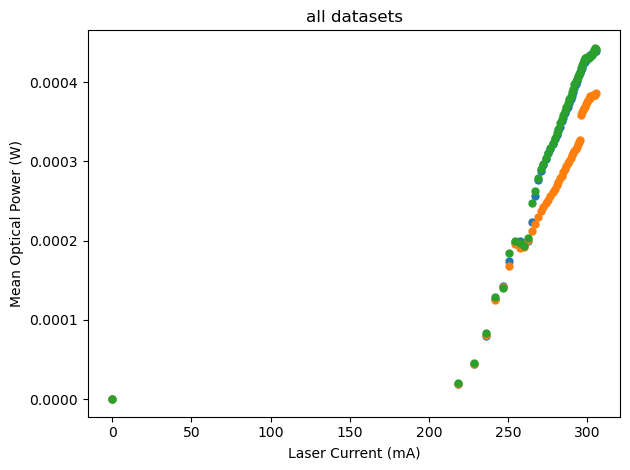

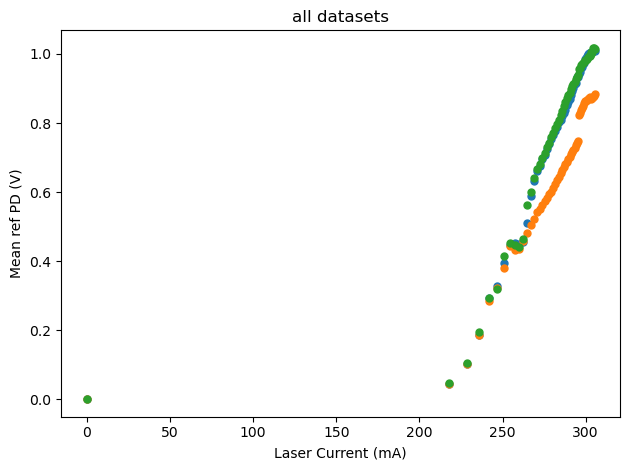

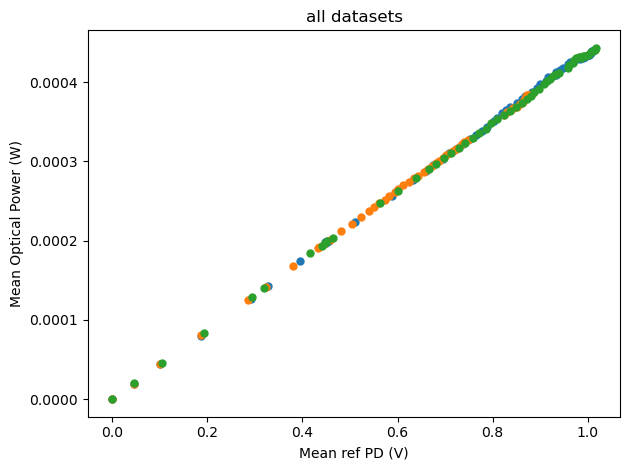

In [13]:
wavelength = '532'
#Sensor_setup1('./Data/setup1/calibration_01092025','calibration_01092025_PD','300uW_FW1',wavelength)
#Sensor_setup1('./Data/setup1/calibration_01092025','calibration_01092025_PD','30uW_FW2',wavelength)
#Sensor_setup1('./Data/setup1/calibration_01092025','calibration_01092025_PD','30uW_FW3',wavelength)
Sensor_setup1('./Data/setup1/calibration_30102025','calibration_30102025_PD','3mW_FW4',wavelength)